### Data import

In [2]:
import pandas as pd
import seaborn as sns
import sys

data = pd.read_json('reviews_class_caixa.json')
data.describe()
#data.loc[:,["text"]]

,text
count,328
unique,325
top,facil acesso
freq,3


### Cleaning text

In [3]:
import spacy
import re
import unicodedata
import string

def setup_abbr():
    file = open("abbr_portuguese.txt", encoding='utf-8')
    abbr_dict = {}

    for line in file:
        w = line.split(";")
        abbr_dict[w[0]] = w[1].replace("\n", "")
    file.close()

    return abbr_dict

def clean(data):
    doc = nlp(data)
    doc_lower = doc.text.lower()
    punct = string.punctuation
    for c in punct:
        doc_lower = doc_lower.replace(c, "")
    doc_without_emoji = emoji_pattern.sub(r'', doc_lower)
    doc_punctuation = u"".join([c for c in unicodedata.normalize('NFKD', doc_without_emoji) if not unicodedata.combining(c)])
    doc_corrected = nlp(" ".join([abbr_dict.get(w, w) for w in doc_punctuation.split()]))
    
    return doc_corrected.text

nlp = spacy.load('pt_core_news_sm')
abbr_dict = setup_abbr()
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

data['cleaned_reviews'] = data['text'].apply(clean)
#data.loc[:,["cleaned_reviews"]]

### Tagging

In [ ]:
import joblib
from nltk import word_tokenize

def wordTag(text):
    tagger = joblib.load('POS_tagger_brill.pkl')
    text = tagger.tag(word_tokenize(text))
    return text
 
data['tag_reviews'] = data['cleaned_reviews'].apply(wordTag)
data.loc[:,["cleaned_reviews", "tag_reviews"]]

### Tokenization

In [4]:
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = word_tokenize(text)
    return text

data['tokenized_reviews'] = data['cleaned_reviews'].apply(tokenize)
#data.loc[:,["tokenized_reviews"]]

### Stopwords remove

In [5]:
from nltk.corpus import stopwords
from spacy.lang.pt.stop_words import STOP_WORDS

def stopwordsRemove(text):
    STOP_WORDS.update(['nao', 'sim', 'caixa', 'nubank', 'aplicativo', 'dinheiro', 'acessar', 'consigo', 'banco', 'email', 'pra', 'pro', 'ta', 'ja', 'so', 'fica'])
    stop_words = list(set(stopwords.words('portuguese') + list(STOP_WORDS)))
    phrase = []
    for word in text:
        if word not in stop_words:
            phrase.append(word)
    return phrase

data['stopwords_reviews'] = data['tokenized_reviews'].apply(stopwordsRemove)
#data.loc[:,["stopwords_reviews"]]

### Frequency Word

['acesso', 'senha', 'assinatura', 'eletronica', 'biometria', 'reconhecimento', 'facial', 'bloqueio', 'chave', 'fraude']
['acess', 'senh', 'assinat', 'eletron', 'biometr', 'reconhec', 'fac', 'bloquei', 'chav', 'fraud']


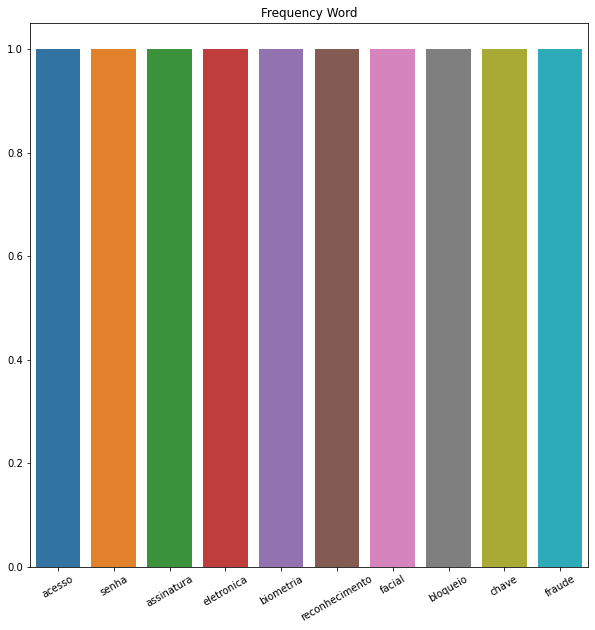

In [6]:
import matplotlib.pyplot as plt
import nltk
from nltk.stem import RSLPStemmer

dataList = data['stopwords_reviews'].to_list()

words = ['acesso', 'senha', 'assinatura', 'eletronica', 'biometria', 'reconhecimento', 'facial', 'bloqueio', 'chave', 'fraude', 'golpe', 'clonagem', 'roubo']


fdist = nltk.FreqDist(words).most_common(10)

mostCommon = []

for word, frequency in fdist:
    mostCommon.append(word)

def stemming(text):
    stemmer = RSLPStemmer()
    phrase = []
    
    for word in text:
        phrase.append(stemmer.stem(word))
        
    return phrase    

print(mostCommon)

mostCommonStem = stemming(mostCommon)

print(mostCommonStem)

fdist = pd.Series(dict(fdist))

fig, ax = plt.subplots(figsize=(10,10))

barplot = sns.barplot(x=fdist.index, y=fdist.values, ax=ax)
plt.title('Frequency Word')
plt.xticks(rotation=30);

### Stemming

In [7]:
import nltk
from nltk.stem import RSLPStemmer

def stemming(text):
    stemmer = RSLPStemmer()
    phrase = []
    for word in text:
        phrase.append(stemmer.stem(word))
    return phrase

data['stem_reviews'] = data['tokenized_reviews'].apply(stemming)
#data.loc[:,["stem_reviews"]]

### Lemmatizer

In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    lemma = " "
    for word in text:
        lemma = wordnet_lemmatizer.lemmatize(word)
        
    return lemma

data['lemma_reviews'] = data['stopwords_reviews'].apply(lemmatize)
data.loc[:,["lemma_reviews"]]

### Phrase junction

In [8]:
def juction(text):
    phrase = []
    for word in text:
        phrase.append(word)
    
    phraseStr = ' '.join(phrase)
    return phraseStr

data['junction'] = data['stem_reviews'].apply(juction)
data.loc[:,["junction"]]

,junction
0,caix est de parabenspel menos o aplic sup o at...
1,oi com fac par cadastr meu celul na cont send ...
2,o aplic ate que e bomach ruim so pra cadastr s...
3,excel aplic de facil acess e operac
4,nao disponibil a configuraca do internet banki...
...,...
323,ess aplic caix tem est ped par vincul uma cont...
324,voc e roub por falh de seguranc do aplic caix ...
325,choc que as pesso deix assim eu tenh so o apli...
326,eu nunc cri tant nom de usuari e senh dentr de...


### Security posts extraction

In [15]:
import spacy
from spacy.matcher import PhraseMatcher

nlp = spacy.load('pt_core_news_sm')

def securityReviewsClassifier(text):
    securityReviews = []
    doc = nlp(text)
    
    securityTerms = mostCommonStem
    patterns = [nlp(term) for term in securityTerms]
    
    matcher = PhraseMatcher(nlp.vocab) 
    matcher.add("SECURITY_PATTERN", patterns)
    
    matches = matcher(doc)
    
    for i in range(0,len(matches)):
        token = doc[matches[i][1]:matches[i][2]]
        securityReviews.append(str(token))
            
    return securityReviews

def class1(text):
    class1Reviews = []
    doc = nlp(text)
    
    class1Terms = ['senh', 'acess']
    patterns = [nlp(term) for term in class1Terms]
    
    matcher = PhraseMatcher(nlp.vocab) 
    matcher.add("SECURITY_PATTERN", patterns)
    
    matches = matcher(doc)
    
    for i in range(0,len(matches)):
        token = doc[matches[i][1]:matches[i][2]]
        class1Reviews.append(str(token))
            
    return class1Reviews

def class2(text):
    class2Reviews = []
    doc = nlp(text)
    
    class2Terms = ['assinat', 'eletron', 'biometr', 'reconhec', 'fac']
    patterns = [nlp(term) for term in class2Terms]
    
    matcher = PhraseMatcher(nlp.vocab) 
    matcher.add("SECURITY_PATTERN", patterns)
    
    matches = matcher(doc)
    
    for i in range(0,len(matches)):
        token = doc[matches[i][1]:matches[i][2]]
        class2Terms.append(str(token))
            
    return class2Reviews

def class3(text):
    class3Reviews = []
    doc = nlp(text)
    
    class3Terms = ['bloquei', 'chav']
    patterns = [nlp(term) for term in class3Terms]
    
    matcher = PhraseMatcher(nlp.vocab) 
    matcher.add("SECURITY_PATTERN", patterns)
    
    matches = matcher(doc)
    
    for i in range(0,len(matches)):
        token = doc[matches[i][1]:matches[i][2]]
        class3Reviews.append(str(token))
            
    return class3Reviews

def class4(text):
    class4Reviews = []
    doc = nlp(text)
    
    class4Terms = ['fraud', 'golp', 'clon', 'roub']
    patterns = [nlp(term) for term in class4Terms]
    
    matcher = PhraseMatcher(nlp.vocab) 
    matcher.add("SECURITY_PATTERN", patterns)
    
    matches = matcher(doc)
    
    for i in range(0,len(matches)):
        token = doc[matches[i][1]:matches[i][2]]
        class4Reviews.append(str(token))
            
    return class4Reviews

# data['security_reviews'] = data['junction'].apply(securityReviewsClassifier)
# data['class1'] = data['junction'].apply(class1)
# data['class2'] = data['junction'].apply(class2)
# data['class3'] = data['junction'].apply(class3)
data['class4'] = data['junction'].apply(class4)
# data.loc[:, 'class1']
# data.loc[:, 'class2']
# data.loc[:, 'class3']
# data.loc[:, 'class4']

In [14]:
import pandas as pd

extracted = []

for i in range(len(data)):
    if len(data.loc[i,'class4'])!=0:
        extracted.append(data.loc[i,'cleaned_reviews'])
        
dfExtracted = pd.DataFrame(extracted, columns=["reviews_classified_all"])
dfExtracted.to_csv("csvresult_class4_caixa.csv", columns = ["reviews_classified_all"])

#data.to_csv("csvresult_all.csv", columns = ["security_reviews"])

In [ ]:
import nltk
from nltk.stem import RSLPStemmer

def stemming(text):
    stemmer = RSLPStemmer()
    phrase = []
    
    for word in text:
        phrase.append(stemmer.stem(word))
        
    return phrase 

words = ['acesso', 'senha', 'assinatura', 'eletronica', 'biometria', 'reconhecimento', 'facial', 'bloqueio', 'chave', 'fraude', 'golpe', 'clonagem', 'roubo']

stem = stemming(words)

print(stem)